In [1]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Exploring Audio Data

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/디지털사운드/13주차/'
# path = 'D:\data/'
path_train = '/content/drive/MyDrive/Colab Notebooks/디지털사운드/13주차/Train/'
df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')
df

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
...,...,...
5430,8725,engine_idling
5431,8726,dog_bark
5432,8727,engine_idling
5433,8728,engine_idling


In [7]:
np.random.seed(0)
#groupby : 반복되는 것을 모두 그루핑
random_class_df = df.groupby('Class').sample()
random_class_df = random_class_df.reset_index(drop=True) #인덱스 삭제 후 저장
random_class_df

,ID,Class
0,6403,air_conditioner
1,7322,car_horn
2,342,children_playing
3,2493,dog_bark
4,3336,drilling
5,8150,engine_idling
6,3548,gun_shot
7,2498,jackhammer
8,2789,siren
9,4599,street_music


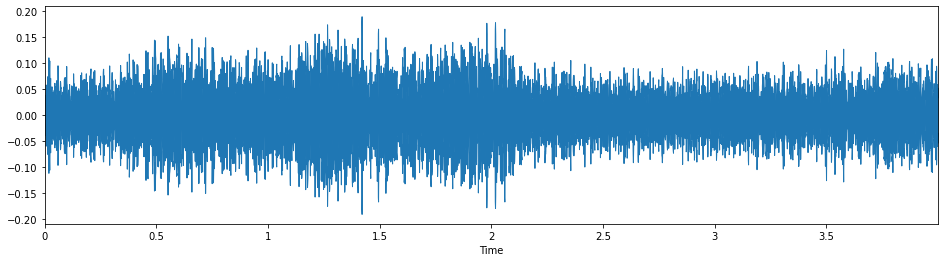

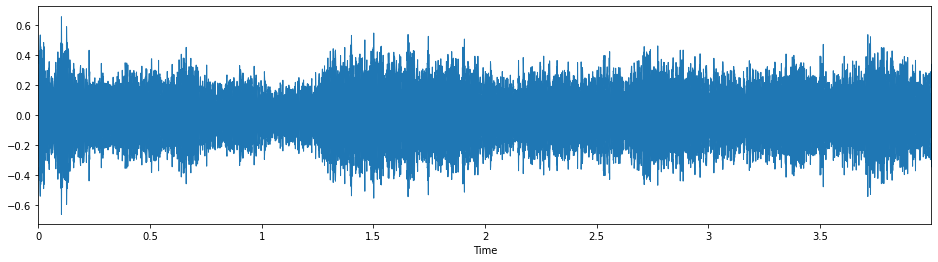

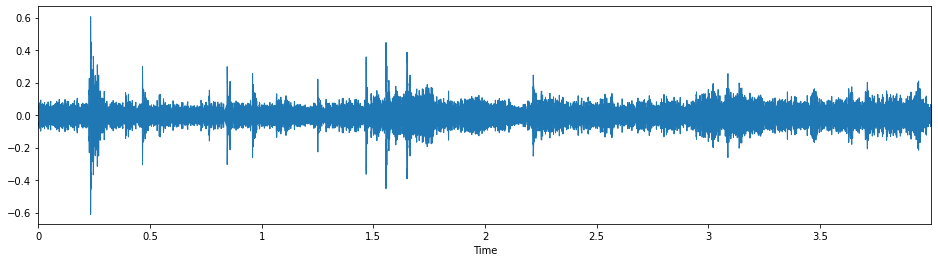

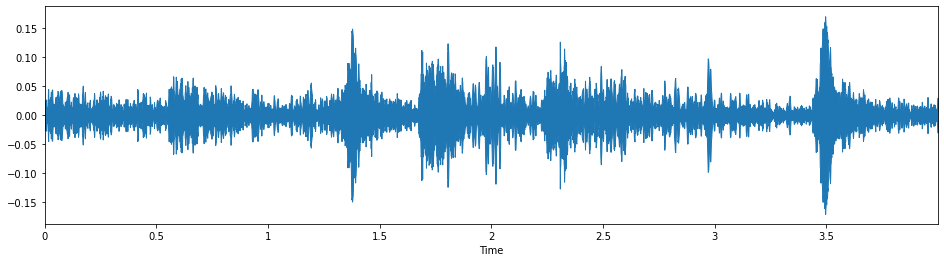

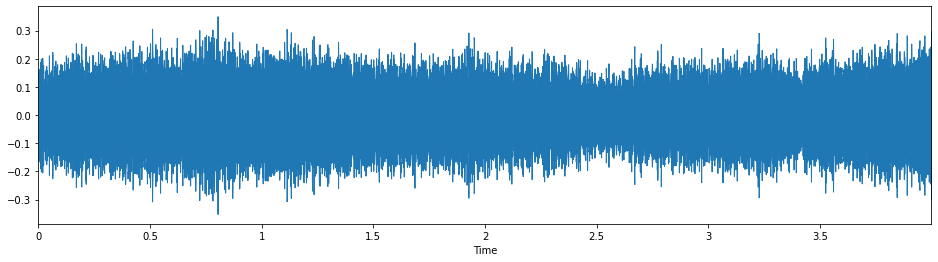

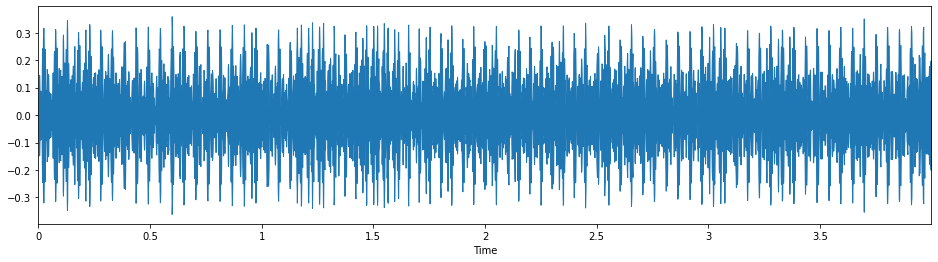

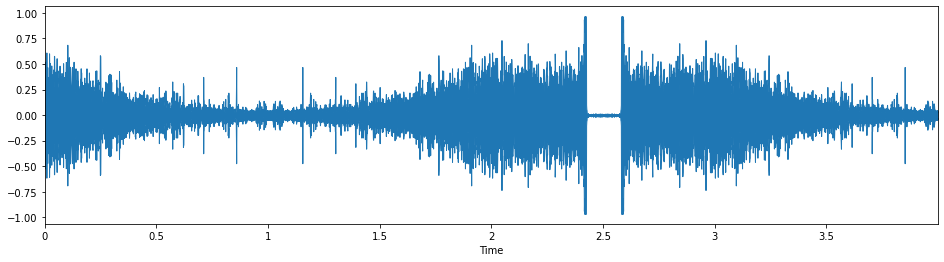

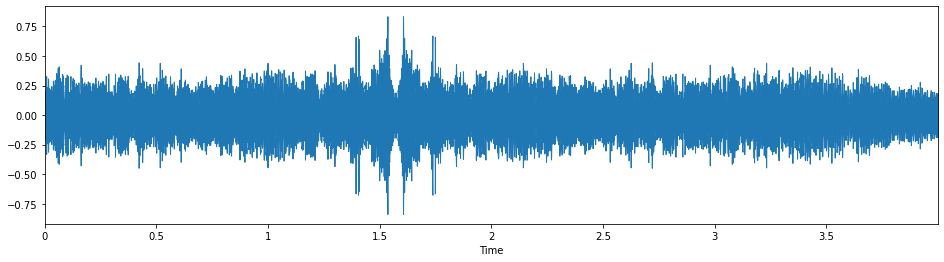

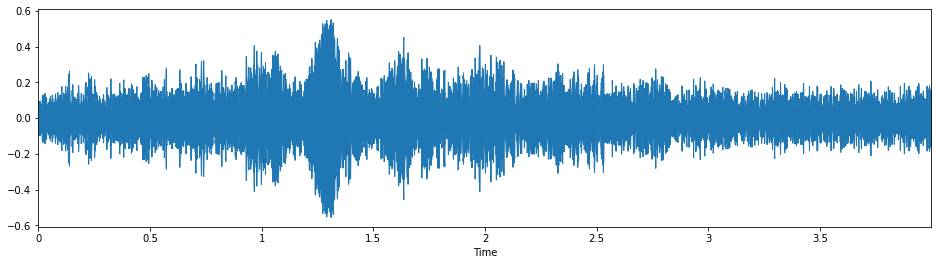

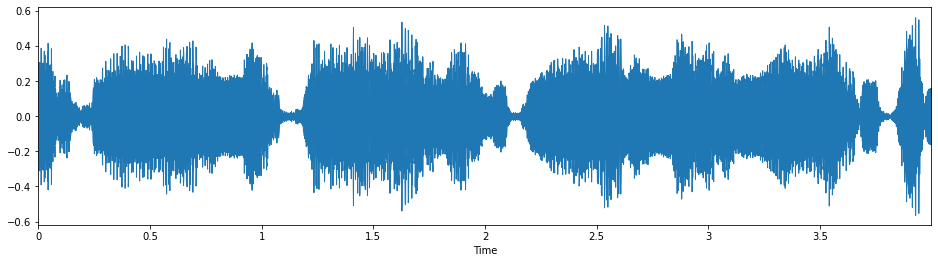

In [8]:
sr = 44100
random_class_data = []
for i in range(10):
    file_name = str(random_class_df['ID'][i])
    wav, sr = librosa.load(path_train+file_name+'.wav', sr=sr)

    #동일한 크기의 음성파일로 만드는 작업
    #불러온 wav값의 shape의 첫번째가 샘플링의 갯수를 의미함.
    if wav.shape[0] < 4*sr: #초 * sr = sampling | 샘플링 값이 지정한 '초'이다. 
       wav = np.pad(wav, int(np.ceil(4*sr-wav.shape[0])), mode='reflect') #np.pad()
       #pad : padding의 약자 / 빈공간을 채워줌.
       #mode = / reflect : 복사, constant : 0값으로 채움
    wav = wav[:4*sr] #4*sr까지의 샘플링 갯수로 슬라이싱함. (4초 맞추기)


    random_class_data.append(wav)
    fig = plt.figure(figsize = (16, 4))
    librosa.display.waveplot(random_class_data[i], sr = sr)

### Data Preprocessing

In [9]:
df['numeric_class'] = df['Class'].astype('category').cat.codes
df

,ID,Class,numeric_class
0,0,siren,8
1,1,street_music,9
2,2,drilling,4
3,3,siren,8
4,4,dog_bark,3
...,...,...,...
5430,8725,engine_idling,5
5431,8726,dog_bark,3
5432,8727,engine_idling,5
5433,8728,engine_idling,5


In [10]:
#test.csv가 정답을 안 가지고 있음.
#모델학습을 위해서 기존 train.csv에서 train 데이터셋과 valid 데이터셋을 나눠줌.

train_df = pd.DataFrame(columns = df.columns)
val_df = pd.DataFrame(columns = df.columns)

#id값의 갯수에 0.8을 곰함.
train_df = df[:int(df['ID'].count()*0.8)]
val_df = df[4348:]
#train_df에서 출력되는 행의 갯수 이후로 슬라이싱해서 valid 데이터셋에 집어넣기.
#4347까지 끝남을 확인해서 4348입력.

train_df

,ID,Class,numeric_class
0,0,siren,8
1,1,street_music,9
2,2,drilling,4
3,3,siren,8
4,4,dog_bark,3
...,...,...,...
4343,7003,jackhammer,7
4344,7004,air_conditioner,0
4345,7005,drilling,4
4346,7006,drilling,4


In [11]:
val_df

,ID,Class,numeric_class
4348,7008,siren,8
4349,7009,children_playing,2
4350,7010,jackhammer,7
4351,7012,drilling,4
4352,7013,air_conditioner,0
...,...,...,...
5430,8725,engine_idling,5
5431,8726,dog_bark,3
5432,8727,engine_idling,5
5433,8728,engine_idling,5




### NN(Neural Network) : shallow DNN


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

In [13]:
import cv2
import sys

#진행도 바
def drawProgressBar(current, total, string = '', barLen = 20):

    percent = current/total
    arrow = ">"
    if percent == 1:
        arrow = ""
    # Carriage return, returns to the begining of line to owerwrite
    sys.stdout.write("\r")
    sys.stdout.write("Progress: [{:<{}}] {}/{}".format("=" * int(barLen * percent) + arrow, 
                                                         barLen, current, total) + string)
    sys.stdout.flush()

In [34]:
audio_data = []
#sample_rates = []
labels = []

tot = len(train_df) #tot = total
curr = 0

for idx in range(tot):
      
    file_name = str(df['ID'][idx]) + '.wav'
    wav, sr = librosa.load(path_train + file_name, sr=44100)
    
    if wav.shape[0] < 4*sr:
        wav = np.pad(wav, int(np.ceil(4*sr-wav.shape[0])), mode='reflect')
    wav = wav[:4*sr]

    audio_data.append(wav)
    train_data = np.stack(audio_data) #audio_data의 각각의 array를 하나의 array로 통합
    #stack : 행렬을 묶어주는 역할을 함. 하나씩 쌓아서 하나의 큰 행렬을 만듦. < 이렇게 해야 tensor가 인식을 함.
    # sample_rates.append(sr)

    labels.append(df['numeric_class'][idx])
    
    #진행바 구현
    curr += 1
    drawProgressBar(curr, tot, barLen = 40)    
    if curr%100==0:
       print("Progress: {}/{}".format(curr, tot))
       print('\n')

print('\n')

Progress: [>                                       ] 100/4348Progress: 100/4348


Progress: [=>                                      ] 200/4348Progress: 200/4348


Progress: [==>                                     ] 300/4348Progress: 300/4348


Progress: [===>                                    ] 400/4348Progress: 400/4348


Progress: [====>                                   ] 500/4348Progress: 500/4348


Progress: [=====>                                  ] 600/4348Progress: 600/4348


Progress: [======>                                 ] 700/4348Progress: 700/4348


Progress: [=======>                                ] 800/4348Progress: 800/4348


Progress: [========>                               ] 900/4348Progress: 900/4348


Progress: [=========>                              ] 1000/4348Progress: 1000/4348


Progress: [==========>                             ] 1100/4348Progress: 1100/4348


Progress: [===========>                            ] 1200/4348Progress: 1200/4348


Progress: 

KeyboardInterrupt: ignored

In [15]:
audio_data

[array([-0.01499939, -0.02107239, -0.02680969, ...,  0.01426697,
        -0.00772095, -0.01293945], dtype=float32),
 array([-0.11386772, -0.15588881, -0.13303   , ...,  0.02990793,
         0.08555287,  0.14019263], dtype=float32),
 array([-0.00099182, -0.0009613 , -0.00112915, ..., -0.06985474,
         0.11282349,  0.10984802], dtype=float32),
 array([0.02770996, 0.05187988, 0.04833984, ..., 0.07351685, 0.06069946,
        0.05378723], dtype=float32),
 array([ 0.10342407,  0.10583496,  0.11009216, ..., -0.025177  ,
        -0.02519226, -0.02548218], dtype=float32),
 array([-0.02790242, -0.03216871, -0.03098492, ..., -0.02125022,
        -0.01895752, -0.01566059], dtype=float32),
 array([-0.00712585, -0.01596069, -0.01582336, ..., -0.01705933,
        -0.00863647, -0.00744629], dtype=float32),
 array([ 0.00079346,  0.06730652,  0.06021118, ..., -0.10250854,
        -0.14646912, -0.15930176], dtype=float32),
 array([-0.23269653, -0.2447815 , -0.2375946 , ..., -0.02090454,
        -0.02

In [22]:
train_data #tensor가 인식하는 방식. 이렇게 안 하면 중단이 됨.

array([[-0.01499939, -0.02107239, -0.02680969, ...,  0.01426697,
        -0.00772095, -0.01293945],
       [-0.11386772, -0.15588881, -0.13303   , ...,  0.02990793,
         0.08555287,  0.14019263],
       [-0.00099182, -0.0009613 , -0.00112915, ..., -0.06985474,
         0.11282349,  0.10984802],
       ...,
       [ 0.00079346,  0.06730652,  0.06021118, ..., -0.10250854,
        -0.14646912, -0.15930176],
       [-0.23269653, -0.2447815 , -0.2375946 , ..., -0.02090454,
        -0.02392578, -0.0224762 ],
       [ 0.00408936,  0.00306702,  0.00073242, ...,  0.02987671,
         0.02938843,  0.02655029]], dtype=float32)

In [31]:
#numpy를 tensor로 바꿔줌.
train_data = torch.from_numpy(train_data)
train_data

tensor([[-0.0150, -0.0211, -0.0268,  ...,  0.0143, -0.0077, -0.0129],
        [-0.1139, -0.1559, -0.1330,  ...,  0.0299,  0.0856,  0.1402],
        [-0.0010, -0.0010, -0.0011,  ..., -0.0699,  0.1128,  0.1098],
        ...,
        [ 0.0008,  0.0673,  0.0602,  ..., -0.1025, -0.1465, -0.1593],
        [-0.2327, -0.2448, -0.2376,  ..., -0.0209, -0.0239, -0.0225],
        [ 0.0041,  0.0031,  0.0007,  ...,  0.0299,  0.0294,  0.0266]])

In [32]:
#list로 받았던 label을 ndarray로 바꿈.
labels = np.array(labels)

train_labels = torch.from_numpy(labels).long()
train_labels

tensor([8, 9, 4, 8, 3, 2, 9, 4, 6, 3])

In [33]:
#위에서 만든 tensor들을 pytorch에 모아줌.
train_data = data_utils.TensorDataset(train_data, train_labels)
train_loader = data_utils.DataLoader(train_data, batch_size = 32, shuffle = True)

In [ ]:
NUM_CLASSES = 10 #10가지 사운드로 분류
NUM_FEATURES =  176400 #4*sr(44100)

In [ ]:
#모델 클래스 정의

class DNN(nn.Module):
  #python 클래스 생성
    def __init__(self):
        super(DNN, self).__init__()
        
        self.fc1 = nn.Linear(in_features = NUM_FEATURES, out_features = 1024)
        
        self.fc2 = nn.Linear(in_features = 1024, out_features = 512)
        
        self.fc3 = nn.Linear(in_features = 512, out_features = 128)
        
        self.fc4 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)
        

        #hidden layer은 이제 경험의 영역, black box.
        #어떤 값을 넣을지는 자기맘.

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) #activation func
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        
        return x

In [ ]:
net = DNN() #net 인스턴스

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [ ]:
EPOCHS = 10
num_train_batches = len(train_loader)

#약 4300개의 wav파일을 학습하고 나면 1 epoch가 끝남

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ":")
    curr = 0
    
    for i, batch in enumerate(train_loader):

        inputs, labels = batch
         #print(inputs)
        outputs = net(inputs) #DNN class의 인스턴스 / wav의 max 값, 예측한 label 값이 들어옴
        loss = loss_fn(outputs, labels) #loss값을 통해 얼마나 학습이 되었는지를 체크
        #loss가 떨어지고, acc가 올라가면 좋음
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1) #여기서 max의 역할. output에서 label만 빼옴.
        #_을 쓰는 이유 : wav의 max값과 예측한 label 값에서, wav의 max 값은 필요가 없어서 버림.
        correct = (predicted == labels).sum().item() #동일한 경우(행)를 다 합쳐서 item(행의 갯수)으로 뽑아냄 > 맞은 갯수가 나옴.
        accuracy = correct/totl
        
        drawProgressBar((i+1), num_train_batches, 
                        '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    
    print('\n\n')


#이렇게 하면 답을 외울 가능성이 있기에, 실제 valid dataset을 이용해서 검증  

### Evaluation with Valid Dataset

In [ ]:
val_df.index

In [ ]:
v_audio_data = []
#val_sr = []
val_labels = []

v_tot = len(val_df)
v_curr = 0

for idx in val_df.index:
      
    file_name = str(df['ID'][idx]) + '.wav'
    wav, sr = librosa.load(path_train + file_name, sr=44100)

    if wav.shape[0] < 4*sr:
        wav = np.pad(wav, int(np.ceil(4*sr-wav.shape[0])), mode='reflect')
    wav = wav[:4*sr]

    v_audio_data.append(wav)
    val_data = np.stack(v_audio_data)
    #val_sr.append(sr)

    val_labels.append(df["numeric_class"][idx])

    v_curr += 1
    
    drawProgressBar(v_curr, v_tot, barLen = 40)
    
    #if curr%100==0:
    #    print("Progress: {}/{}".format(v_curr, v_tot))
    #    print('\n')
print('\n')

In [ ]:
val_data = torch.from_numpy(val_data)

In [ ]:
val_labels = np.array(val_labels)
val_labels = torch.from_numpy(val_labels).long()
val_labels

In [ ]:
val_data = data_utils.TensorDataset(val_data, val_labels)
val_loader = data_utils.DataLoader(val_data, batch_size = 32, shuffle = True)

In [ ]:
def evaluate(model, eval_data):

#이미 모델이 생성되었으니, 경사하강법X
    model.eval() #model = 위에서 생성한 모델 인스턴스
    num_eval_batches = len(eval_data)
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for i, batch in enumerate(eval_data):
            inputs, labels = batch
            #print(inputs.shape)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            # print(labels.size(0))
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            drawProgressBar((i+1), num_eval_batches)
        
        accuracy = correct/total
        eval_loss = total_loss/num_eval_batches
    
    return accuracy, eval_loss

In [ ]:
val_acc, val_loss = evaluate(net, val_loader)

print("\n\nValidation accuracy: {:.4f}".format(round(val_acc, 4)))
print("Validation loss: {:.4f}".format(round(val_loss, 4)))

정확도가 20%밖에 안됨.
